In [6]:
# import numpy as np
# import torch
# import xarray as xr

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# # Load dataset
# ds = xr.open_dataset('../dat/RBC_Output.nc')  # adjust path

# # Grid selection
# z_full = ds['z_aac'].values
# x_full = ds['x_caa'].values

# z_sel_idx = np.linspace(0, len(z_full)-1, 50, dtype=int)
# x_sel_idx = np.linspace(0, len(x_full)-1, 128, dtype=int)

# z_vals = z_full[z_sel_idx]
# x_vals = x_full[x_sel_idx]

# def slice_field(field, z_dim, x_dim):
#     return np.array(field.isel({z_dim: z_sel_idx, x_dim: x_sel_idx}).values, dtype=np.float32)

# max_time_steps = 50
# b = slice_field(ds['b'].isel(time=slice(0, max_time_steps)), 'z_aac', 'x_caa')
# u = slice_field(ds['u'].isel(time=slice(0, max_time_steps)), 'z_aac', 'x_faa')
# w = slice_field(ds['w'].isel(time=slice(0, max_time_steps)), 'z_aaf', 'x_caa')
# p_dyn = slice_field(ds['p_dyn'].isel(time=slice(0, max_time_steps)), 'z_aac', 'x_caa')

# time = np.array(ds['time'].isel(time=slice(0, max_time_steps)).values, dtype=np.float32)

# # Multiple Δt setup: (1,2,3 step diffs)
# delta_ts = [1, 2, 3]
# X_list, Y_list, dt_list, t_list = [], [], [], []

# for dt in delta_ts:
#     if max_time_steps - dt <= 0:
#         continue
#     delta_b = b[dt:] - b[:-dt]                                 # (T - dt, z, x)
#     inputs = np.stack([u[:-dt], w[:-dt], p_dyn[:-dt]], axis=1) # (T - dt, 3, z, x)
#     times = time[dt:]                                          # (T - dt,)
    
#     Δt_arr = np.full((inputs.shape[0], 1), (time[dt] - time[0]), dtype=np.float32)
    
#     X_list.append(inputs)
#     Y_list.append(delta_b)
#     dt_list.append(Δt_arr)
#     t_list.append(times)

# X_np = np.concatenate(X_list, axis=0)
# Y_np = np.concatenate(Y_list, axis=0)
# Δt_np = np.concatenate(dt_list, axis=0)
# t_np = np.concatenate(t_list, axis=0)

# # Normalization
# subset = min(10, X_np.shape[0])
# X_mean, X_std = X_np[:subset].mean(), X_np[:subset].std()
# Y_mean, Y_std = Y_np[:subset].mean(), Y_np[:subset].std()

# X_norm = (X_np - X_mean) / (X_std + 1e-8)
# Y_norm = (Y_np - Y_mean) / (Y_std + 1e-8)

# t_min, t_max = t_np.min(), t_np.max()
# t_norm = (t_np - t_min) / (t_max - t_min)

# Δt_min, Δt_max = Δt_np.min(), Δt_np.max()
# Δt_norm = (Δt_np - Δt_min) / (Δt_max - Δt_min)

# # To tensors
# X_tensor = torch.tensor(X_norm, dtype=torch.float32).to(device)    # (N, 3, 50, 128)
# Y_tensor = torch.tensor(Y_norm, dtype=torch.float32).to(device)    # (N, 50, 128)
# t_tensor = torch.tensor(t_norm, dtype=torch.float32).unsqueeze(1).to(device)    # (N, 1)
# Δt_tensor = torch.tensor(Δt_norm, dtype=torch.float32).unsqueeze(1).to(device)  # (N, 1)

# print("✅ Preprocessing done:", X_tensor.shape, Y_tensor.shape, t_tensor.shape, Δt_tensor.shape)


In [7]:
# train_idx = np.arange(0, int(0.75 * X_tensor.shape[0]))
# test_idx = np.arange(int(0.75 * X_tensor.shape[0]), X_tensor.shape[0])

# X_train = X_tensor[train_idx]
# t_train = t_tensor[train_idx].view(-1, 1)          # Ensure (batch, 1)
# Δt_train = Δt_tensor[train_idx].view(-1, 1)        # Ensure (batch, 1)
# Y_train = Y_tensor[train_idx]

# X_test = X_tensor[test_idx]
# t_test = t_tensor[test_idx].view(-1, 1)            # Ensure (batch, 1)
# Δt_test = Δt_tensor[test_idx].view(-1, 1)          # Ensure (batch, 1)
# Y_test = Y_tensor[test_idx]
# print("✅ Train/Test split done:", X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)


In [8]:
# !pip install netCDF4
# !pip install h5netcdf



In [9]:
import numpy as np
import torch
import xarray as xr

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ========== 1. Load Dataset ==========
ds = xr.open_dataset('../dat/RBC_Output.nc')  # Adjust path as needed

z_full = ds['z_aac'].values
x_full = ds['x_caa'].values

z_sel_idx = np.linspace(0, len(z_full)-1, 50, dtype=int)
x_sel_idx = np.linspace(0, len(x_full)-1, 128, dtype=int)

z_vals = z_full[z_sel_idx]
x_vals = x_full[x_sel_idx]

def slice_field(field, z_dim, x_dim):
    return np.array(field.isel({z_dim: z_sel_idx, x_dim: x_sel_idx}).values, dtype=np.float32)

max_time_steps = 50
b = slice_field(ds['b'].isel(time=slice(0, max_time_steps)), 'z_aac', 'x_caa')
u = slice_field(ds['u'].isel(time=slice(0, max_time_steps)), 'z_aac', 'x_faa')
w = slice_field(ds['w'].isel(time=slice(0, max_time_steps)), 'z_aaf', 'x_caa')
p_dyn = slice_field(ds['p_dyn'].isel(time=slice(0, max_time_steps)), 'z_aac', 'x_caa')

time = np.array(ds['time'].isel(time=slice(0, max_time_steps)).values, dtype=np.float32)

# ========== 2. Split Time Indices ==========
usable_time_steps = max_time_steps - 1  # For Δt=1

train_cutoff = int(0.75 * usable_time_steps)
train_time_idx = np.arange(0, train_cutoff + 1)   # Includes last usable for Δt
test_time_idx = np.arange(train_cutoff + 1, max_time_steps)

time_train_np = time[train_time_idx]
time_test_np = time[test_time_idx]

# ========== 3. Create Training Data (Δt = 1 to 5) ==========
delta_ts_train = [1, 2, 3, 4, 5]
X_train_list, Y_train_list, Δt_train_list, t_train_list = [], [], [], []

for dt in delta_ts_train:
    valid_idx = train_time_idx[train_time_idx <= (train_time_idx[-1] - dt)]
    if len(valid_idx) == 0:
        continue

    X_t = np.stack([u[valid_idx], w[valid_idx], p_dyn[valid_idx]], axis=1)
    Y_t = b[valid_idx + dt] - b[valid_idx]
    t_t = time[valid_idx + dt]
    Δt_t = (time[valid_idx + dt] - time[valid_idx]).reshape(-1, 1)

    X_train_list.append(X_t)
    Y_train_list.append(Y_t)
    Δt_train_list.append(Δt_t)
    t_train_list.append(t_t)

X_train_np = np.concatenate(X_train_list, axis=0)
Y_train_np = np.concatenate(Y_train_list, axis=0)
Δt_train_np = np.concatenate(Δt_train_list, axis=0)
t_train_np = np.concatenate(t_train_list, axis=0)

# ========== 4. Create Test Data (Δt = 1 only) ==========
dt_test = 1
valid_idx_test = test_time_idx[test_time_idx <= test_time_idx[-1] - dt_test]

X_test_np = np.stack([u[valid_idx_test], w[valid_idx_test], p_dyn[valid_idx_test]], axis=1)
Y_test_np = b[valid_idx_test + dt_test] - b[valid_idx_test]
t_test_np = time[valid_idx_test + dt_test]
Δt_test_np = (time[valid_idx_test + dt_test] - time[valid_idx_test]).reshape(-1, 1)

# ========== 5. Normalization ==========
subset = min(10, X_train_np.shape[0])
X_mean, X_std = X_train_np[:subset].mean(), X_train_np[:subset].std()
Y_mean, Y_std = Y_train_np[:subset].mean(), Y_train_np[:subset].std()

X_train_norm = (X_train_np - X_mean) / (X_std + 1e-8)
Y_train_norm = (Y_train_np - Y_mean) / (Y_std + 1e-8)

X_test_norm = (X_test_np - X_mean) / (X_std + 1e-8)
Y_test_norm = (Y_test_np - Y_mean) / (Y_std + 1e-8)

t_min, t_max = t_train_np.min(), t_train_np.max()
t_train_norm = (t_train_np - t_min) / (t_max - t_min)
t_test_norm = (t_test_np - t_min) / (t_max - t_min)

Δt_min, Δt_max = Δt_train_np.min(), Δt_train_np.max()
Δt_train_norm = (Δt_train_np - Δt_min) / (Δt_max - Δt_min)
Δt_test_norm = (Δt_test_np - Δt_min) / (Δt_max - Δt_min)

# ========== 6. Convert to Tensors ==========
X_train = torch.tensor(X_train_norm, dtype=torch.float32).to(device)
Y_train = torch.tensor(Y_train_norm, dtype=torch.float32).to(device)
t_train = torch.tensor(t_train_norm, dtype=torch.float32).unsqueeze(1).to(device)
Δt_train = torch.tensor(Δt_train_norm, dtype=torch.float32).unsqueeze(1).to(device)

X_test = torch.tensor(X_test_norm, dtype=torch.float32).to(device)
Y_test = torch.tensor(Y_test_norm, dtype=torch.float32).to(device)
t_test = torch.tensor(t_test_norm, dtype=torch.float32).unsqueeze(1).to(device)
Δt_test = torch.tensor(Δt_test_norm, dtype=torch.float32).unsqueeze(1).to(device)

# ========== 7. Summary ==========
print("✅ Train:", X_train.shape, Y_train.shape, t_train.shape, Δt_train.shape)
print("✅ Test :", X_test.shape, Y_test.shape, t_test.shape, Δt_test.shape)
print("✅ Time arrays:", time_train_np.shape, time_test_np.shape)


C:\Users\deban\AppData\Local\Temp\ipykernel_20264\294467512.py:8: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  ds = xr.open_dataset('../dat/RBC_Output.nc')  # Adjust path as needed


✅ Train: torch.Size([170, 3, 50, 128]) torch.Size([170, 50, 128]) torch.Size([170, 1]) torch.Size([170, 1, 1])
✅ Test : torch.Size([12, 3, 50, 128]) torch.Size([12, 50, 128]) torch.Size([12, 1]) torch.Size([12, 1, 1])
✅ Time arrays: (37,) (13,)


In [10]:
import torch.nn as nn
import torch.nn.functional as F

class DeepONetCNN(nn.Module):
    def __init__(self):
        super(DeepONetCNN, self).__init__()
        # Spatial branch (CNN)
        self.branch = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 1, kernel_size=3, padding=1),
            nn.ReLU()
        )
        # Time trunk (MLP for t and Δt)
        self.trunk = nn.Sequential(
            nn.Linear(2, 128),
            nn.ReLU(),
            nn.Linear(128, 50 * 128),
            nn.Tanh()
        )

    def forward(self, x, t, Δt):
        B_out = self.branch(x).squeeze(1)                # (B, 50, 128)
        
        # Fix shapes
        t = t.view(-1, 1)                                # Ensure (B, 1)
        Δt = Δt.view(-1, 1)                              # Ensure (B, 1)
        T_in = torch.cat([t, Δt], dim=1)                 # (B, 2)
        
        T_out = self.trunk(T_in).view(-1, 50, 128)       # (B, 50, 128)
        
        return B_out * T_out



In [11]:
def compute_physics_loss(model, X_in, t_in, Δt_in, κ=1e-6, dz=1.0, dx=1.0):
    """
    Computes the physics loss: ∂b/∂t + u ∂b/∂x + w ∂b/∂z = κ (∂²b/∂x² + ∂²b/∂z²)
    using central differences on both x and z.
    """
    pred = model(X_in, t_in, Δt_in)  # (B, 50, 128)

    u = X_in[:, 0, :, :]  # (B, 50, 128)
    w = X_in[:, 1, :, :]  # (B, 50, 128)

    # Compute b_x and crop u accordingly (crop along x)
    b_x = (pred[:, :, 2:] - pred[:, :, :-2]) / (2 * dx)  # (B, 50, 126)
    u_mid = u[:, :, 1:-1]                                # (B, 50, 126)

    # Compute b_z and crop w accordingly (crop along z)
    b_z = (pred[:, 2:, :] - pred[:, :-2, :]) / (2 * dz)  # (B, 48, 128)
    w_mid = w[:, 1:-1, :]                                # (B, 48, 128)

    # To combine these, we need intersection: crop both in z and x → center region
    # Crop b_x/u to remove 1 row along z (top & bottom)
    b_x_crop = b_x[:, 1:-1, :]    # (B, 48, 126)
    u_crop = u_mid[:, 1:-1, :]    # (B, 48, 126)

    # Crop b_z/w to remove 1 col along x (left & right)
    b_z_crop = b_z[:, :, 1:-1]    # (B, 48, 126)
    w_crop = w_mid[:, :, 1:-1]    # (B, 48, 126)

    # Advection term: now both are (B, 48, 126)
    advection = u_crop * b_x_crop + w_crop * b_z_crop

    # Second derivatives
    b_xx = (pred[:, :, :-2] - 2 * pred[:, :, 1:-1] + pred[:, :, 2:]) / (dx**2)  # (B, 50, 126)
    b_xx_crop = b_xx[:, 1:-1, :]  # (B, 48, 126)

    b_zz = (pred[:, :-2, :] - 2 * pred[:, 1:-1, :] + pred[:, 2:, :]) / (dz**2)  # (B, 48, 128)
    b_zz_crop = b_zz[:, :, 1:-1]  # (B, 48, 126)

    diffusion = κ * (b_xx_crop + b_zz_crop)  # (B, 48, 126)

    # Final residual
    residual = advection - diffusion

    # Physics loss
    phy_loss = torch.mean(residual**2)

    return phy_loss


In [12]:
model = DeepONetCNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
mse = nn.MSELoss()

for epoch in range(3000):
    model.train()
    optimizer.zero_grad()
    
    pred = model(X_train, t_train, Δt_train)
    
    obs_loss = mse(pred, Y_train)
    phy_loss = compute_physics_loss(model, X_train, t_train, Δt_train)
    
    smoothness_loss = torch.mean((pred[:, :, 1:] - pred[:, :, :-1])**2) + torch.mean((pred[:, 1:, :] - pred[:, :-1, :])**2)
    
    total_loss = obs_loss + 0.1 * phy_loss + 0.01 * smoothness_loss
    total_loss.backward()
    optimizer.step()
    
    if epoch % 500 == 0:
        print(f"Epoch {epoch}: Total={total_loss.item():.5f}, Obs={obs_loss.item():.5f}, Phy={phy_loss.item():.5f}")

# Save the model
torch.save(model.state_dict(), 'pinn_2Dprofile_model.pth')

Epoch 0: Total=2.85710, Obs=2.85689, Phy=0.00104
Epoch 500: Total=0.92697, Obs=0.84313, Phy=0.38159
Epoch 1000: Total=0.72795, Obs=0.63651, Phy=0.40631
Epoch 1500: Total=0.82974, Obs=0.73764, Phy=0.40074
Epoch 2000: Total=0.61621, Obs=0.52068, Phy=0.42433
Epoch 2500: Total=0.57934, Obs=0.48030, Phy=0.43640


C:\Users\deban\AppData\Local\Temp\ipykernel_20264\1030960897.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('pinn_2Dprofile_model.pth')

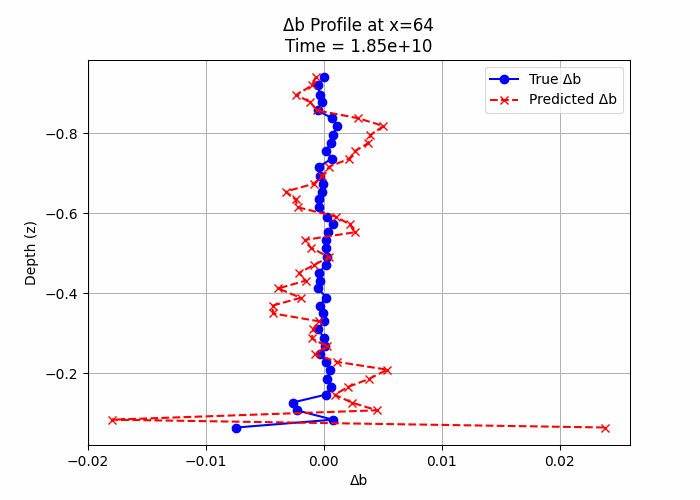

In [14]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import Image, display, HTML

# ----------------------------
# Evaluate on Test Set
# ----------------------------
model.load_state_dict(torch.load('pinn_2Dprofile_model.pth'))
model.to(device)

model.eval()
with torch.no_grad():
    pred_test = model(X_test, t_test, Δt_test).cpu().numpy()   # (N_test, 50, 128)
    true_test = Y_test.cpu().numpy()                           # (N_test, 50, 128)

# Unnormalize predictions and targets (optional but better for visualization)
pred_test_un = pred_test * Y_std + Y_mean
true_test_un = true_test * Y_std + Y_mean

# ----------------------------
# Plotting Δb(z) Profile at Fixed x
# ----------------------------
x_idx = 64                   # Fixed x position (center)
trim_start, trim_end = 3, -3  # Optional trimming to avoid edge noise
z_trimmed = z_vals[trim_start:trim_end]

b_true_list = []
b_pred_list = []

for i in range(true_test_un.shape[0]):
    b_true_i = true_test_un[i, trim_start:trim_end, x_idx]
    b_pred_i = pred_test_un[i, trim_start:trim_end, x_idx]
    b_true_list.append(b_true_i)
    b_pred_list.append(b_pred_i)

# ----------------------------
# Time for X-axis labels → use time_test_np
# ----------------------------
fig, ax = plt.subplots(figsize=(7, 5))

def update(frame):
    ax.clear()
    ax.plot(b_true_list[frame], z_trimmed, label='True Δb', marker='o', color='blue')
    ax.plot(b_pred_list[frame], z_trimmed, label='Predicted Δb', linestyle='--', marker='x', color='red')
    ax.set_title(f'Δb Profile at x={x_idx}\nTime = {time_test_np[frame]:.2e}')
    ax.set_xlabel('Δb')
    ax.set_ylabel('Depth (z)')
    ax.invert_yaxis()
    ax.legend()
    ax.grid(True)

ani = animation.FuncAnimation(fig, update, frames=len(b_true_list), blit=False, interval=1000)

# Save and display
ani.save('PINN_deltab_overlay.gif', writer='pillow', fps=0.5)
display(Image(filename='PINN_deltab_overlay.gif'))

plt.close(fig)
display(HTML(ani.to_jshtml()))
